In [1]:
!pip install -q -U transformers==4.26.1
!pip install -q -U diffusers==0.14.0
!pip install -q -U onnx==1.13.1
# !pip install -q -U onnxruntime==1.14.1
!pip install -q -U onnxruntime-gpu==1.14.1
!pip install -q -U basicsr==1.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 21.8 MB/s eta 0:

In [ ]:
!pip install -U -q xformers

In [2]:
%cd /content
# !git clone https://github.com/cloneofsimo/t2i-adapter-diffusers.git
!git clone https://github.com/ffletcherr/t2i-adapter-diffusers.git

/content
Cloning into 't2i-adapter-diffusers'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 180 (delta 77), reused 142 (delta 50), pack-reused 0
Receiving objects: 100% (180/180), 12.30 MiB | 27.62 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [1]:
import inspect
from typing import Union, Optional, List, Callable, Dict, Any

import torch
from diffusers.pipelines.onnx_utils import ORT_TO_NP_TYPE
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput

def torch_run_sd(
    self,
    adapter_features,
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
    latents: Optional[torch.FloatTensor] = None,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
    callback_steps: int = 1,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
):
    # 0. Default height and width to unet
    height = height or self.unet.config.sample_size * self.vae_scale_factor
    width = width or self.unet.config.sample_size * self.vae_scale_factor

    # 1. Check inputs. Raise error if not correct
    self.check_inputs(
        prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
    )

    # 2. Define call parameters
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    device = self._execution_device
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt
    prompt_embeds = self._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
    )

    # 4. Prepare timesteps
    self.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = self.scheduler.timesteps

    # 5. Prepare latent variables
    num_channels_latents = self.unet.in_channels
    latents = self.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
        latents,
    )

    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

    # 7. Denoising loop
    num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
    with self.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=cross_attention_kwargs,
                f_1=adapter_features[0],
                f_2=adapter_features[1],
                f_3=adapter_features[2],
                f_4=adapter_features[3],
            ).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                progress_bar.update()
                if callback is not None and i % callback_steps == 0:
                    callback(i, t, latents)

    if output_type == "latent":
        image = latents
        has_nsfw_concept = None
    elif output_type == "pil":
        # 8. Post-processing
        image = self.decode_latents(latents)

        # 9. Run safety checker
        # image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        has_nsfw_concept = False

        # 10. Convert to PIL
        image = self.numpy_to_pil(image)
    else:
        # 8. Post-processing
        image = self.decode_latents(latents)

        # 9. Run safety checker
        # image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        has_nsfw_concept = False

    # Offload last model to CPU
    if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
        self.final_offload_hook.offload()
    
    if not return_dict:
        return (image, has_nsfw_concept)

    return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

In [2]:
%cd /content/t2i-adapter-diffusers

import gc

import torch

from diffusers import StableDiffusionPipeline
from t2i_adapters import patch_pipe

StableDiffusionPipeline.run_by_adapter = torch_run_sd

# 1. Define model and patch to t2i-adapter
model_id = "CompVis/stable-diffusion-v1-4"  # "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               torch_dtype=torch.float16,
                                               safety_checker=None,
                                               feature_extractor=None,
                                               requires_safety_checker=False)

pipe = pipe.to("cuda")
patch_pipe(pipe)

torch.cuda.empty_cache()
gc.collect()

/content/t2i-adapter-diffusers


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'projection_class_embeddings_input_dim': None} were passed to T2IAdapterUNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


13

In [7]:
%cd /content/t2i-adapter-diffusers
from t2i_adapters import patch_pipe, Adapter, T2IAdapterUNet2DConditionModel

import cv2
from basicsr.utils import img2tensor

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

device = "cuda"
# 2 Extract features with adapter
adapter = Adapter.from_pretrained("canny").to(device)

/content/t2i-adapter-diffusers


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


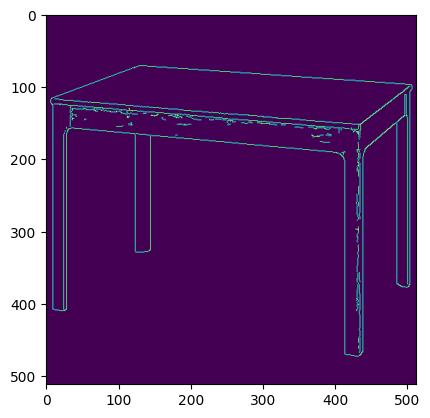

In [8]:
# 2.1 prepare condition image
canny = cv2.imread("/content/table.png")
canny = cv2.resize(canny, (512, 512))
canny = cv2.Canny(canny, 50, 100)[..., None]
plt.imshow(canny)
plt.show()
canny = img2tensor(canny).unsqueeze(0) / 255.
canny = canny.to(device)

# 2.2 prepare feature
with torch.no_grad():
    adapter_features = adapter(canny)

In [9]:
import pickle
with open("/content/adapter_features.pkl", "wb") as f:
    pickle.dump(adapter_features, f)

In [3]:
import pickle
with open("/content/adapter_features.pkl", "rb") as f:
    adapter_features = pickle.load(f)

In [4]:
from diffusers.models.cross_attention import AttnProcessor2_0
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler


pipe.unet.set_attn_processor(AttnProcessor2_0())
pipe.enable_attention_slicing()
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
torch.cuda.empty_cache()
gc.collect()

24

  0%|          | 0/20 [00:00<?, ?it/s]

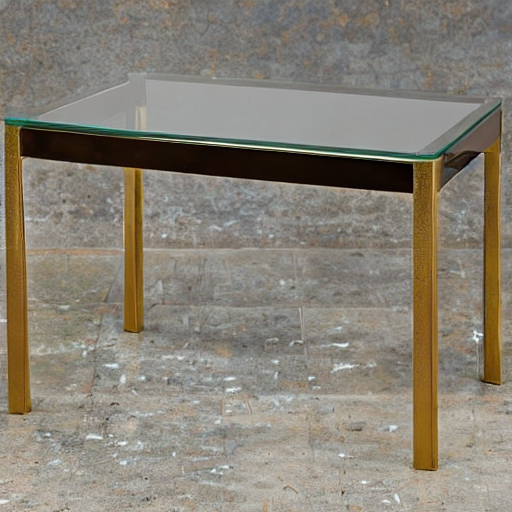

In [5]:
DEFAULT_NEGATIVE_PROMPT = ["longbody", "lowres", "bad anatomy", "bad hands", "missing fingers", "extra digit", "fewer digits", "cropped", "worst quality", "low quality"]
DEFAULT_NEGATIVE_PROMPT = ", ".join(DEFAULT_NEGATIVE_PROMPT)
prompt = "glass-head table with gold metal legs"
with torch.no_grad():
    out = pipe.run_by_adapter(adapter_features=adapter_features, prompt=prompt, negative_prompt=DEFAULT_NEGATIVE_PROMPT, num_inference_steps=20)
out.images[0]